In [274]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from padasip.filters import FilterRLS
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

sns.set()


def plot_pred(y_true, y_pred):
    ax = sns.relplot(x=np.reshape(y_true, (-1)), y=np.reshape(y_pred, (-1)), kind='scatter')
    ax.set(xlabel='True Target', ylabel='Prediction')


def plot_weights(w_true, w_pred):
    ax = sns.relplot(x=np.reshape(w_true, (-1)), y=np.reshape(w_pred, (-1)), kind='scatter')
    ax.set(xlabel='True Weights', ylabel='Evaluation Weights')


def plot_error(error):
    ax = sns.relplot(data=error, kind='line').set_axis_labels('Iteration', 'Error^2')
    ax.set(ylim=(0, 10))


# closed-form solution
def OLS(X, y):
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w


# gradient descent
def LR_gradient_descent(X, y, return_error=False):
    lr = 0.05
    epoch = 100
    error = []
    w = np.random.randn(X.shape[1], 1)
    for _ in range(epoch):
        if return_error:
            error.append(1 / len(X) * np.linalg.norm(X @ w - y) ** 2)
        gradient = 1 / len(X) * (X.T @ X @ w - X.T @ y)
        w -= lr * gradient
    if return_error:
        return w, np.array(error)
    return w


# stochastic gradient descent
def LR_stochastic_gd(X, y, return_error=False, momentum=False):
    lr = 0.01
    epoch = 1
    error = []
    dim = X.shape[1]
    w = np.random.randn(dim, 1)

    beta1 = 0.9
    m = 0

    for _ in range(epoch):
        np.random.seed(42)
        index = np.random.permutation(len(X))
        for i in index:
            if return_error:
                error.append(1 / len(X) * np.linalg.norm(X @ w - y) ** 2)
            e = X[i] @ w - y[i]
            gradient = e * X[np.newaxis, i].T
            if momentum:
                m = beta1 * m + (1 - beta1) * gradient
                w -= lr * m
            else:
                w -= lr * gradient
    if return_error:
        return w, np.array(error)
    return w


def LR_mini_batch_gd(X, y, return_error=False):
    lr = 0.05
    epoch = 5
    error = []
    dim = X.shape[1]
    w = np.random.randn(dim, 1)

    batch_size = 32
    index = np.random.permutation(len(X))
    batch_X = []
    batch_y = []
    for i in range(0, len(X), batch_size):
        j = i + batch_size if i + batch_size <= len(X) else len(X)
        batch_X.append(X[index[i: j]])
        batch_y.append(y[index[i: j]])

    for _ in range(epoch):
        for i in range(len(batch_X)):
            if return_error:
                error.append(1 / len(X) * np.linalg.norm(X @ w - y) ** 2)
            gradient = 1 / len(batch_X[i]) * (batch_X[i].T @ batch_X[i] @ w - batch_X[i].T @ batch_y[i])
            w -= lr * gradient

    if return_error:
        return w, np.array(error)
    return w


# recursive least squares
def RLS(x, d, return_error=False, return_pred=False):
    lambda_ = 1.0
    eps = 0.1
    dim = x.shape[1]
    w = np.zeros((dim, 1))
    P = 1 / eps * np.identity(dim)

    error = []
    y_pred = np.zeros(len(x))

    np.random.seed(42)
    index = np.random.permutation(len(X))
    for i in index:
        xi = x[i].reshape(-1, 1)
        k = 1 / lambda_ * P @ xi / (1 + 1 / lambda_ * xi.T @ P @ xi)
        P = 1 / lambda_ * P - 1 / lambda_ * k @ xi.T @ P
        y_pred[i] = (xi.T @ w)[0][0]
        e = y_pred[i] - d[i]
        if return_error:
            error.append(e**2)
        w = w - e * k
    r = [w]
    if return_error:
        r.append(np.array(error))
    if return_pred:
        r.append(y_pred)
    return tuple(r)


# recursive least squares
def RLS_padasip(x, d, return_error=False, return_pred=False):
    f = FilterRLS(n=x.shape[1], mu=0.98, eps=0.1, w='zeros')
    y_pred, error, weights = f.run(d, x)
    r = [weights[-1]]
    if return_error:
        r.append(error**2)
    if return_pred:
        r.append(y_pred)
    return tuple(r)


def LMS(x, d, return_error=False, return_pred=False, momentum=False, lr=0.05):
    dim = X.shape[1]
    w = np.random.randn(dim, 1)
    alpha = 0.01

    beta1 = 0.9
    beta2 = 0.999
    m = np.zeros((dim, 1))
    V = np.zeros(dim)
    eps = 1e-7

    y_pred = np.zeros(len(x))
    error = []

    np.random.seed(42)
    index = np.random.permutation(len(X))
    for i in index:
        y_pred[i] = x[i] @ w
        e = y_pred[i] - d[i]
        if return_error:
            error.append(e ** 2)

        if momentum:
            lr_NAG = np.diag(lr / np.sqrt(V + eps))
            w_NAG = w - lr_NAG @ m
            e = (x[i] @ w_NAG) - d[i]

        gradient = e * X[np.newaxis, i].T + 2 * alpha * w

        V = beta2 * V + (1 - beta2) * (gradient.flatten())**2
        lr_prime = np.diag(lr / np.sqrt(V + eps))

        if momentum:
            m = beta1 * m + (1 - beta1) * gradient
            w -= lr_prime @ m
        else:
            w -= lr_prime @ gradient

    r = [w]
    if return_error:
        r.append(np.array(error))
    if return_pred:
        r.append(y_pred)
    return tuple(r)

In [ ]:
N, p = 500, 300
np.random.seed(42)
X = np.random.randn(N, p)
w_true = np.random.randn(p, 1)
y = X @ w_true + 0.8 * np.random.randn(N, 1)

# w = OLS(X, y)
# y_pred = X @ w
# plot_pred(y, y_pred)
# plt.savefig('figures/OLS_pred.jpg')
# plot_weights(w_true, w)
# plt.savefig('figures/OLS_weights.jpg')

# w, err = LR_gradient_descent(X, y, return_error=True)
# y_pred = X @ w
# plot_pred(y, y_pred)
# plt.savefig('figures/GD_pred.jpg')
# plot_weights(w_true, w)
# plt.savefig('figures/GD_weights.jpg')
# plot_error(err)
# plt.savefig('figures/GD_error.jpg')

# w, err = LR_stochastic_gd(X, y, return_error=True)
# y_pred = X @ w
# plot_pred(y, y_pred)
# plt.savefig('figures/stable_SGD_pred.jpg')
# plot_weights(w_true, w)
# plt.savefig('figures/stable_SGD_weights.jpg')
# plot_error(err)
# plt.savefig('figures/stable_SGD_error.jpg')

# w, err = LR_mini_batch_gd(X, y, return_error=True)
# y_pred = X @ w
# plot_pred(y, y_pred)
# plt.savefig('figures/mBGD_pred.jpg')
# plot_weights(w_true, w)
# plt.savefig('figures/mBGD_weights.jpg')
# plot_error(err)
# plt.savefig('figures/mBGD_error.jpg')

# w, err, y_pred = RLS_padasip(X, y.flatten(), return_error=True, return_pred=True)
# plot_pred(y, y_pred)
# plt.savefig('figures/padasip_pred.jpg')
# plot_weights(w_true, w)
# plt.savefig('figures/padasip_weights.jpg')
# plot_error(err)
# plt.savefig('figures/padasip_error.jpg')

w, err, y_pred = RLS(X, y, return_error=True, return_pred=True)
plot_pred(y, y_pred)
plt.savefig('figures/RLS_300_pred.jpg')
plot_weights(w_true, w)
plt.savefig('figures/RLS_300_weights.jpg')
plot_error(err)
plt.savefig('figures/RLS_300_error.jpg')

plt.show()

In [ ]:
df = pd.read_csv('data/NASA_airfoil_self_noise.csv')

df

# EDA #

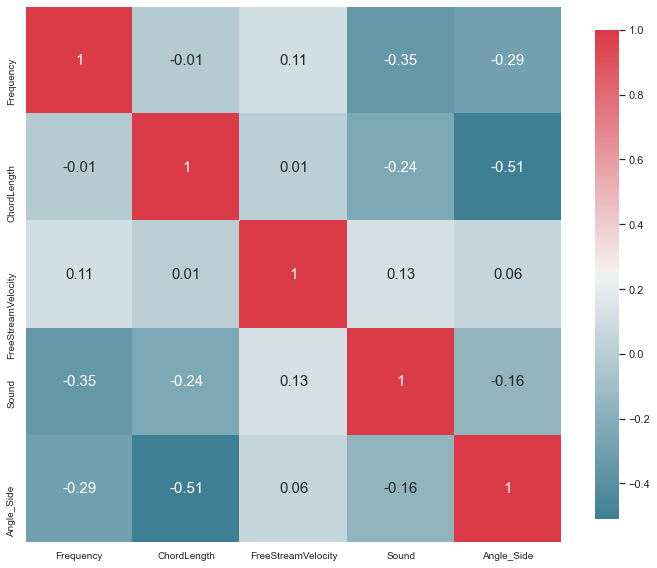

In [145]:
df_2 = df.copy()
pca = PCA(1)
Angle_Side = pca.fit_transform(df.loc[:, ['AngleAttack', 'SuctionSide']])
df_2 = df_2.drop(['AngleAttack', 'SuctionSide'], axis=1)
df_2['Angle_Side'] = Angle_Side
df_2['Frequency'] = np.log(df_2['Frequency'])
df_2['ChordLength'] = np.sqrt(df_2['ChordLength'])

corr = df_2.corr().round(2)
_, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
hm = sns.heatmap(
    corr,
    cmap=cmap,
    square=True,
    cbar_kws={'shrink': .9},
    ax=ax,
    annot=True,
    annot_kws={'fontsize': 15}
)
hm.tick_params(labelsize=10)
# plt.savefig('figures/heatmap_2.jpg')



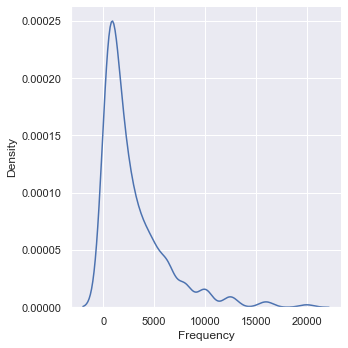

In [143]:
sns.displot(df_2.Frequency, kind='kde')
plt.savefig('Frequency_feat.jpg')

# Offline Learning #

r2 score: 0.9071623852342041


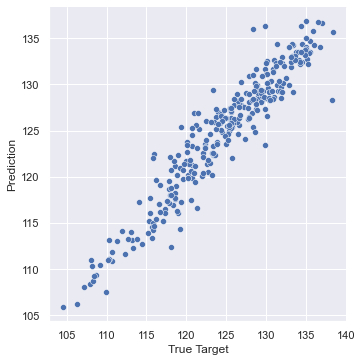

In [146]:
y = df_2['Sound']
X = df_2.drop(['Sound'], axis=1)

# feature engineering
X = (X - X.max(axis=0)) / (X.max(axis=0) - X.min(axis=0))
polynomial_features = PolynomialFeatures(degree=5, include_bias=False)
X = polynomial_features.fit_transform(X)

# cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# feature selection
feature_dim = 100
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
importance_sort = np.argsort(rfr.feature_importances_)[::-1]
selected_features = importance_sort[:feature_dim]
X_train = X_train[:, selected_features]
X_test = X_test[:, selected_features]
rank = np.linalg.matrix_rank(X_train)
if rank < feature_dim:
    pca = PCA(n_components=rank)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

# add bias
X_train = np.column_stack((X_train, np.ones(len(X_train))))
X_test = np.column_stack((X_test, np.ones(len(X_test))))

w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
y_pred = X_test @ w
print('r2 score:', r2_score(y_test, y_pred))

ax = sns.relplot(x=y_test, y=y_pred, kind='scatter')
ax.set(xlabel='True Target', ylabel='Prediction')
plt.show()

# Online Learning #

In [238]:
y = df_2['Sound']
X = df_2.drop(['Sound'], axis=1)

X = X.to_numpy()
y = y.to_numpy()
index = np.arange(len(X))
np.random.seed(42)
np.random.shuffle(index)
y = y[index]
X = X[index]

X = (X - X.max(axis=0)) / (X.max(axis=0) - X.min(axis=0))
y = (y - y.mean(axis=0)) / y.std(axis=0)
polynomial_features = PolynomialFeatures(degree=5, include_bias=False)
X = polynomial_features.fit_transform(X)
print(X.shape)

feature_dim = 100
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X, y)
importance_sort = np.argsort(rfr.feature_importances_)[::-1]
selected_features = importance_sort[:feature_dim]
X = X[:, selected_features]
rank = np.linalg.matrix_rank(X)
if rank < feature_dim:
    pca = PCA(n_components=rank)
    X = pca.fit_transform(X)

# add bias
X = np.column_stack((X, np.ones(len(X))))

(1503, 125)


In [270]:
pd.DataFrame(X[:, :50])

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.355067,3.461418,-0.046189,0.535708,1.547688,-0.140208,0.081899,0.019572,0.071774,-0.026164,...,0.006735,-0.004947,0.022784,-0.007412,-0.001818,-0.011479,0.007733,-0.001095,-0.001450,-0.002230
1,0.360704,0.612528,0.329184,-0.947458,-0.335114,-0.222128,0.189409,-0.044781,-0.246250,-0.093987,...,0.005890,0.000439,-0.005721,0.010335,0.013401,-0.003741,-0.001517,-0.005908,0.002747,0.001556
2,-1.179355,0.493850,-0.200375,-0.440294,0.290122,0.037034,-0.091281,0.098635,0.055057,0.277525,...,0.007723,0.001124,-0.002952,0.006133,-0.011722,-0.000249,-0.001368,-0.002706,-0.002267,-0.001361
3,3.616533,0.107894,-2.810960,-0.033975,-0.277419,0.528912,0.164286,-0.373814,0.559720,0.055817,...,-0.005273,-0.017326,0.000993,0.000809,-0.009484,0.004355,0.000713,0.003466,-0.001548,-0.000530
4,0.617982,-1.036361,-1.349582,0.831437,-0.159966,-0.414443,0.106951,0.362675,0.017842,-0.103840,...,0.000366,-0.011387,-0.013062,0.000681,-0.010188,-0.008954,0.012255,0.002154,0.000488,-0.003146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,3.116653,0.318649,2.377718,0.329659,-0.247280,-0.004109,-0.456554,0.410866,0.320571,0.428153,...,-0.003588,-0.017844,0.004154,0.011358,0.003128,0.011937,0.010762,-0.002754,0.001304,0.008545
1499,-0.496957,-0.437865,0.034512,1.072277,-0.296011,0.133709,-0.117344,-0.000244,-0.307750,-0.142426,...,0.001272,0.003542,-0.003011,0.006702,-0.006703,0.006242,-0.000773,-0.003001,0.011646,0.000864
1500,1.357249,0.198862,0.892801,-0.187601,-0.301852,-0.119825,-0.069290,-0.035278,-0.196229,0.133783,...,-0.018444,-0.004470,0.006487,-0.006840,0.001005,0.001342,0.004967,-0.002325,0.001046,-0.003135
1501,1.150986,1.729482,1.425072,-0.423456,-0.534720,-0.567722,0.498114,0.266259,0.050663,-0.050310,...,-0.006987,-0.001300,-0.006471,-0.001231,0.001194,0.004589,-0.005865,-0.006117,0.002117,0.001361


0.21651506423950195


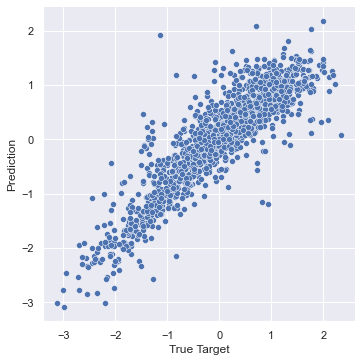

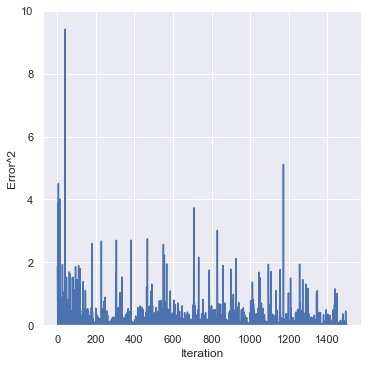

In [284]:
import time
t = time.time()
w, err, y_pred = RLS(X, y, return_error=True, return_pred=True)
print(time.time() - t)

ax = sns.relplot(x=y, y=y_pred, kind='scatter')
ax.set(xlabel='True Target', ylabel='Prediction')
plt.savefig('rls_airfoil_predictions.jpg')
plot_error(err)
plt.savefig('rls_airfoil_error.jpg')

plt.show()

0.1274888515472412


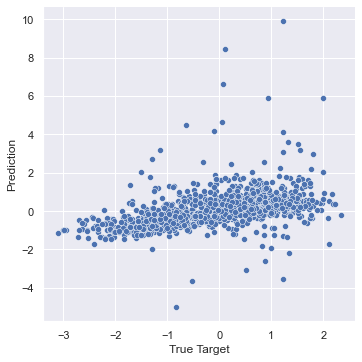

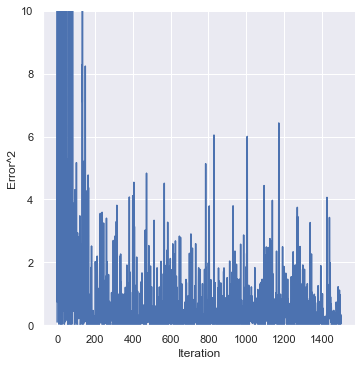

In [285]:
t = time.time()
w, err, y_pred = LMS(X, y, return_error=True, return_pred=True, momentum=True, lr=0.01)
print(time.time() - t)
ax = sns.relplot(x=y, y=y_pred.flatten(), kind='scatter')
ax.set(xlabel='True Target', ylabel='Prediction')
# plt.savefig('lms_airfoil_predictions.jpg')
plot_error(err)
# plt.savefig('lms_airfoil_error.jpg')
plt.show()